In [2]:
# Install relevant packages
import torch
import torch.nn as nn
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
# set seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Section 1: Graph UNet
### Objective: We will create an Erdos-Renyi Random Graph and go through the UNet architecture Step-by-Step

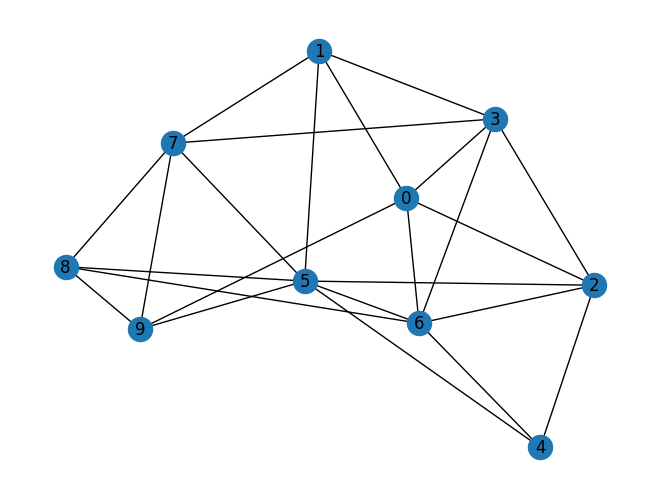

In [4]:
num_nodes = 10
edge_probability = 0.6
num_features = 3

# create graph structure
G = nx.erdos_renyi_graph(num_nodes, edge_probability)
nx.draw(G, with_labels=True)


A = torch.tensor(nx.to_numpy_array(G) + np.eye(num_nodes)).float() # add self loops too

In [5]:
# D^{-1}A
#Exercise create Normalised Adjacency function by dividing the values by the sum of the degrees:

def norm_g(g):
    degrees = torch.sum(g, 1)
    g = g / degrees
    return g

# D^{-1}A
#Exercise create Degree Normalised Adjacency function: 
A_norm = norm_g(A)

# create random node features (num_nodes, 3)
H = torch.randn(num_nodes, num_features)

print('Normalised Ajdacency Matrix: ')
print(A_norm)
print('Node Features: ')
print(H)

Normalised Ajdacency Matrix: 
tensor([[0.1667, 0.2000, 0.1667, 0.1667, 0.0000, 0.0000, 0.1429, 0.0000, 0.0000,
         0.2000],
        [0.1667, 0.2000, 0.0000, 0.1667, 0.0000, 0.1250, 0.0000, 0.1667, 0.0000,
         0.0000],
        [0.1667, 0.0000, 0.1667, 0.1667, 0.2500, 0.1250, 0.1429, 0.0000, 0.0000,
         0.0000],
        [0.1667, 0.2000, 0.1667, 0.1667, 0.0000, 0.0000, 0.1429, 0.1667, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1667, 0.0000, 0.2500, 0.1250, 0.1429, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.2000, 0.1667, 0.0000, 0.2500, 0.1250, 0.1429, 0.1667, 0.2000,
         0.2000],
        [0.1667, 0.0000, 0.1667, 0.1667, 0.2500, 0.1250, 0.1429, 0.0000, 0.2000,
         0.0000],
        [0.0000, 0.2000, 0.0000, 0.1667, 0.0000, 0.1250, 0.0000, 0.1667, 0.2000,
         0.2000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.1429, 0.1667, 0.2000,
         0.2000],
        [0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.1667, 0.2000

# Graph UNet Architecture
![Graph UNet Architecture](figures/unet_arch.png)

## 1) GCN step
![GCN step](figures/gcn.png)

In [16]:
# step 1 - pass through GCN layer

class GCN(nn.Module):

    def __init__(self, in_dim, out_dim):
        super(GCN, self).__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.act = nn.Sigmoid()

    def forward(self, g, h):
        h = torch.matmul(g, h)
        h = self.proj(h)
        h = self.act(h)
        return h

gcn_model = GCN(num_features, num_features)

In [17]:
H_k = gcn_model(A_norm, H)
print('Normalised Ajdacency Matrix: ')
print(A_norm)
print('Node Features: ')
print(H_k)

Normalised Ajdacency Matrix: 
tensor([[0.1667, 0.2000, 0.1667, 0.1667, 0.0000, 0.0000, 0.1429, 0.0000, 0.0000,
         0.2000],
        [0.1667, 0.2000, 0.0000, 0.1667, 0.0000, 0.1250, 0.0000, 0.1667, 0.0000,
         0.0000],
        [0.1667, 0.0000, 0.1667, 0.1667, 0.2500, 0.1250, 0.1429, 0.0000, 0.0000,
         0.0000],
        [0.1667, 0.2000, 0.1667, 0.1667, 0.0000, 0.0000, 0.1429, 0.1667, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1667, 0.0000, 0.2500, 0.1250, 0.1429, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.2000, 0.1667, 0.0000, 0.2500, 0.1250, 0.1429, 0.1667, 0.2000,
         0.2000],
        [0.1667, 0.0000, 0.1667, 0.1667, 0.2500, 0.1250, 0.1429, 0.0000, 0.2000,
         0.0000],
        [0.0000, 0.2000, 0.0000, 0.1667, 0.0000, 0.1250, 0.0000, 0.1667, 0.2000,
         0.2000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.1429, 0.1667, 0.2000,
         0.2000],
        [0.1667, 0.0000, 0.0000, 0.0000, 0.0000, 0.1250, 0.0000, 0.1667, 0.2000

# 2) Pooling
![pooling](figures/pooling.png)

In [18]:
# Step 2 - pooling
# pooling parameters
proj = nn.Linear(num_features, 1) # learnable projection layer
k = 3 # number of (top) nodes to select 
sigmoid = nn.Sigmoid()

# 2) Pooling Architecture
![pooling_arch](figures/pooling_arch.png)

In [19]:
# get node scores (Exercise)
# Use the projection Layer of shape (num_features x 1) and H_k of shape (num_nodes x num_features) to get a weight for each node.
# Use a softmax on these weights to get a score per node
# -> Sigmoid(H_k x proj)


weights = proj(H_k).squeeze() # multiply by projection
scores = sigmoid(weights)
print(scores)

tensor([0.3739, 0.3774, 0.3817, 0.3775, 0.3786, 0.3740, 0.3826, 0.3726, 0.3688,
        0.3696], grad_fn=<SigmoidBackward0>)


In [20]:
sigmoid(proj(H_k).squeeze())

tensor([0.3739, 0.3774, 0.3817, 0.3775, 0.3786, 0.3740, 0.3826, 0.3726, 0.3688,
        0.3696], grad_fn=<SigmoidBackward0>)

In [21]:
sigmoid(proj(H_k))

tensor([[0.3739],
        [0.3774],
        [0.3817],
        [0.3775],
        [0.3786],
        [0.3740],
        [0.3826],
        [0.3726],
        [0.3688],
        [0.3696]], grad_fn=<SigmoidBackward0>)

In [22]:
# select top_k nodes
values, idx = torch.topk(scores, k)
print('top scores:')
print(values)
print('top scoring nodes:')
print(idx)

top scores:
tensor([0.3826, 0.3817, 0.3786], grad_fn=<TopkBackward0>)
top scoring nodes:
tensor([6, 2, 4])


In [23]:
# get new_H
H_pooled = H_k[idx, :] # only look at top k nodes
values = torch.unsqueeze(values, -1)
H_pooled = torch.mul(H_pooled, values) # multiply by scores (after softmax)
print(H_pooled)

tensor([[0.1920, 0.2740, 0.1000],
        [0.2036, 0.2578, 0.1037],
        [0.1968, 0.2520, 0.1278]], grad_fn=<MulBackward0>)


In [24]:
# Exercise: Convert The degree normalised adjacency (A_norm) back to binary adjacency matrix

A = A_norm.bool().float() # convert to binary adj as we want to recalculate norm adjacency matrix with new degrees

# in the paper they use the kth graph power
#A  = torch.matmul(A, A).bool().float()


A_new_graph = A[idx][:, idx]

A_pooled = norm_g(A_new_graph)

print('indices selected: {}'.format(idx))
print('edges connected to node {} in original graph {}'.format(idx[0], A[idx[0]].nonzero())) 
print(A_pooled)

indices selected: tensor([6, 2, 4])
edges connected to node 6 in original graph tensor([[0],
        [2],
        [3],
        [4],
        [5],
        [6],
        [8]])
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]])


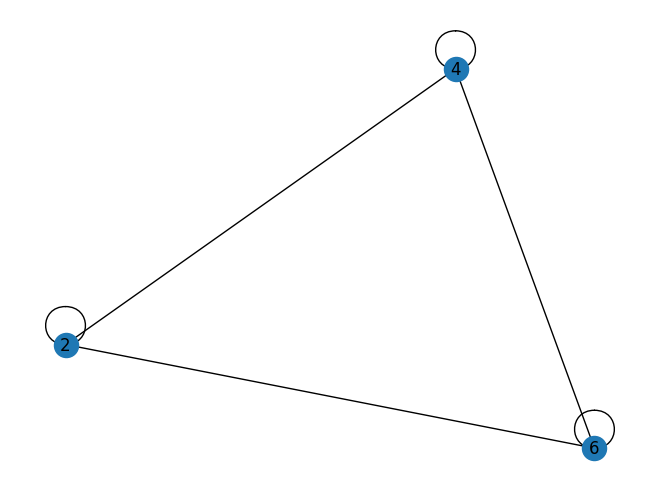

In [25]:
# Exercise: Visualise The new adjacency matrix with networkx

G_pool = nx.from_numpy_array(np.asarray(A_new_graph))

labels = {}
for i in range(k):
    labels[i] = idx[i].item()

nx.draw(G_pool, labels=labels)

# 3) UnPooling
![unpooling](figures/unpool.png)

In [26]:
# Step 3 unpooling

In [27]:
# currently have H_pooled as the node features and A_pooled as the edge features
# idx are the nodes that have been filtered

In [28]:
H_unpool = torch.zeros([num_nodes, num_features])
H_unpool[idx] = H_pooled

print('new node features')
print(H_unpool)
print('Degree Normalized Adjacency Matrix')
print(A_norm)

new node features
tensor([[0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.2036, 0.2578, 0.1037],
        [0.0000, 0.0000, 0.0000],
        [0.1968, 0.2520, 0.1278],
        [0.0000, 0.0000, 0.0000],
        [0.1920, 0.2740, 0.1000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000]], grad_fn=<IndexPutBackward0>)
Degree Normalized Adjacency Matrix
tensor([[0.1667, 0.2000, 0.1667, 0.1667, 0.0000, 0.0000, 0.1429, 0.0000, 0.0000,
         0.2000],
        [0.1667, 0.2000, 0.0000, 0.1667, 0.0000, 0.1250, 0.0000, 0.1667, 0.0000,
         0.0000],
        [0.1667, 0.0000, 0.1667, 0.1667, 0.2500, 0.1250, 0.1429, 0.0000, 0.0000,
         0.0000],
        [0.1667, 0.2000, 0.1667, 0.1667, 0.0000, 0.0000, 0.1429, 0.1667, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.1667, 0.0000, 0.2500, 0.1250, 0.1429, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.2000, 0.1667, 0.0000, 0.2500, 0.1250, 0.1429, 0.1667, 0.2000,
 

In [29]:
# putting it all together - code taken from https://github.com/HongyangGao/Graph-U-Nets/tree/master

import torch
import torch.nn as nn
import numpy as np


class GraphUnet(nn.Module):

    def __init__(self, ks, in_dim, out_dim, dim, act, drop_p):
        super(GraphUnet, self).__init__()
        self.ks = ks
        self.bottom_gcn = GCN(dim, dim, act, drop_p)
        self.down_gcns = nn.ModuleList()
        self.up_gcns = nn.ModuleList()
        self.pools = nn.ModuleList()
        self.unpools = nn.ModuleList()
        self.l_n = len(ks)
        for i in range(self.l_n):
            self.down_gcns.append(GCN(dim, dim, act, drop_p))
            self.up_gcns.append(GCN(dim, dim, act, drop_p))
            self.pools.append(Pool(ks[i], dim, drop_p))
            self.unpools.append(Unpool(dim, dim, drop_p))

    def forward(self, g, h):
        adj_ms = []
        indices_list = []
        down_outs = []
        hs = []
        org_h = h
        for i in range(self.l_n):
            h = self.down_gcns[i](g, h)
            adj_ms.append(g)
            down_outs.append(h)
            g, h, idx = self.pools[i](g, h)
            indices_list.append(idx)
        h = self.bottom_gcn(g, h)
        for i in range(self.l_n):
            up_idx = self.l_n - i - 1
            g, idx = adj_ms[up_idx], indices_list[up_idx]
            g, h = self.unpools[i](g, h, down_outs[up_idx], idx)
            h = self.up_gcns[i](g, h)
            h = h.add(down_outs[up_idx])
            hs.append(h)
        h = h.add(org_h)
        hs.append(h)
        return hs


class GCN(nn.Module):

    def __init__(self, in_dim, out_dim, act, p):
        super(GCN, self).__init__()
        self.proj = nn.Linear(in_dim, out_dim)
        self.act = act
        self.drop = nn.Dropout(p=p) if p > 0.0 else nn.Identity()

    def forward(self, g, h):
        h = self.drop(h) # they have added dropout
        h = torch.matmul(g, h)
        h = self.proj(h)
        h = self.act(h)
        return h


class Pool(nn.Module):

    def __init__(self, k, in_dim, p):
        super(Pool, self).__init__()
        self.k = k
        self.sigmoid = nn.Sigmoid()
        self.proj = nn.Linear(in_dim, 1)
        self.drop = nn.Dropout(p=p) if p > 0 else nn.Identity() # added dropout here

    def forward(self, g, h):
        Z = self.drop(h)
        weights = self.proj(Z).squeeze()
        scores = self.sigmoid(weights)
        return top_k_graph(scores, g, h, self.k)


class Unpool(nn.Module):

    def __init__(self, *args):
        super(Unpool, self).__init__()

    def forward(self, g, h, pre_h, idx):
        new_h = h.new_zeros([g.shape[0], h.shape[1]])
        new_h[idx] = h
        return g, new_h


def top_k_graph(scores, g, h, k):
    num_nodes = g.shape[0]
    values, idx = torch.topk(scores, max(2, int(k*num_nodes))) # make sure k works based on number of current nodes
    new_h = h[idx, :]
    values = torch.unsqueeze(values, -1)
    new_h = torch.mul(new_h, values)
    un_g = g.bool().float()
    un_g = torch.matmul(un_g, un_g).bool().float() # second power to reduce chance of isolated nodes
    un_g = un_g[idx, :]
    un_g = un_g[:, idx]
    g = norm_g(un_g)
    return g, new_h, idx


def norm_g(g):
    degrees = torch.sum(g, 1)
    g = g / degrees
    return g

In [30]:
# Homework / Possible Coursework: Train this model end-to-end

# Section 1 Continued: GraphVAE: https://arxiv.org/abs/1802.03480
### Objective: We will see another Encoder-Decoder model based on variational autoencoders

In [31]:
from torch_geometric.nn import VGAE, GCNConv
import torch.nn.functional as F
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.datasets import ZINC

# Zinc Database
![zinc](figures/zinc_database.png)

In [32]:
# Load Zinc Dataset

dataset = ZINC(root='/tmp/ZINC', subset=True)
train_frac = 0.95
test_frac = 1 - train_frac

train_data_list, test_data_list = [], []

for idx, data in enumerate(dataset):
    if idx < train_frac*len(dataset):
        train_data_list.append(data)
    else:
        test_data_list.append(data)
        
print('number training examples is {}'.format(len(train_data_list)))
print('number test examples is {}'.format(len(test_data_list)))

number training examples is 9500
number test examples is 500


# VAE architecture
![VAE](figures/vae.png)

In [37]:
"""
Here we define our encoder. This takes as input X (node features) and A (connectivity) and returns mu and sigma
"""

class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv_mu = GCNConv(2 * out_channels, out_channels)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        # GCN layer to generate embedding
        x = self.conv1(x, edge_index).relu()
        # GCN layers to predict mu, sigma
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

# Inner Product Decoder
### ![VAE](figures/inner_product.png)

In [39]:
class InnerProductDecoder(torch.nn.Module):
    def forward(self, z, edge_index,
                sigmoid=True):
        """Decodes the latent variables :obj:`z` into edge probabilities for
        all given node-pairs :obj:`edge_index`.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        """Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (torch.Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        # Exercise: Implement Inner Product Decoder here
        adj =  torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj

In [40]:
# define hyperparameters
in_channels, out_channels, lr, n_epochs = 1, 16, 1e-2, 5
gen_graphs, threshold, batch_size, add_self_loops = 1, 0.5, 10, True

In [41]:
# define model as VGAE(encoder=our encoder, decoder = our decoder) in pytorch geometric
model = VGAE(VariationalGCNEncoder(in_channels, out_channels), InnerProductDecoder())

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train_loader = DataLoader(train_data_list, batch_size=batch_size, shuffle=True)

In [42]:
# show the model layers
model

VGAE(
  (encoder): VariationalGCNEncoder(
    (conv1): GCNConv(1, 32)
    (conv_mu): GCNConv(32, 16)
    (conv_logstd): GCNConv(32, 16)
  )
  (decoder): InnerProductDecoder()
)

### Loss functions

In [43]:
# Define reconstruction loss (maximise prob when edge exists. Minimise prob for edges that don't exist)

from torch_geometric.utils import negative_sampling

def recon_loss(model, z, edge_index, EPS=1e-15):
    """Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :obj:`pos_edge_index` and negative
        sampled edges.
    """
    
    pos_loss = -torch.log(
            model.decoder(z, edge_index) + EPS).mean()
    
    neg_edge_index = negative_sampling(edge_index, z.size(0))
    
    neg_loss = -torch.log(1 - model.decoder(z, neg_edge_index) +
            EPS).mean()
    
    return pos_loss + neg_loss

In [44]:
# define KL loss on the embedding space


def kl_loss(model):
    mu =  model.__mu__
    logstd = model.__logstd__
    
    return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))

In [45]:
def train():
    model.train()
    loss_all = 0

    for data in train_loader:
        # define optimizer
        optimizer.zero_grad()
        # Generate encoding
        z = model.encode(data.x.float(), data.edge_index)
        # calc loss
        loss = recon_loss(model, z, data.edge_index) 
        loss = loss + (1 / data.num_nodes) * kl_loss(model)
        loss.backward()
        loss_all += data.y.size(0) * float(loss)
        optimizer.step()
    return loss_all / len(train_loader.dataset)

In [46]:
for epoch in range(1, n_epochs + 1):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

Epoch: 001, Loss: 1.3582
Epoch: 002, Loss: 1.2616
Epoch: 003, Loss: 1.2489
Epoch: 004, Loss: 1.2443
Epoch: 005, Loss: 1.2417


In [ ]:
# visualising new graphs

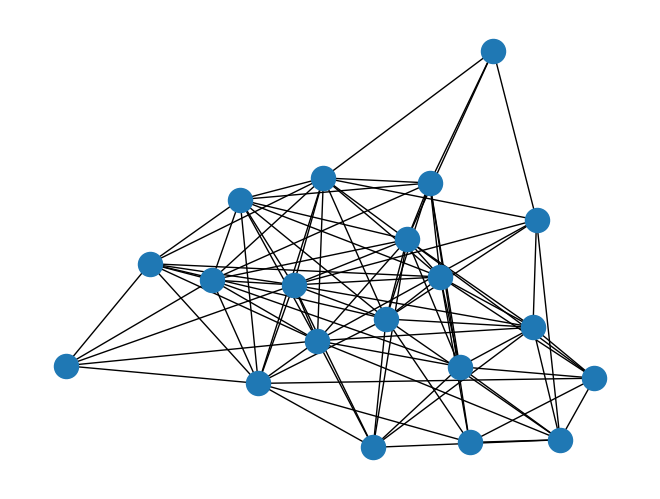

In [61]:
number_nodes = 20
z = torch.randn(number_nodes, out_channels)
graph_adj = model.decoder.forward_all(z)
adj_binary = np.asarray((graph_adj > threshold).int())

pred_G = nx.from_numpy_array(adj_binary)
pred_G.remove_edges_from(nx.selfloop_edges(pred_G))
nx.draw(pred_G)

In [59]:
adj_binary

array([[1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1],
       [0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1],
       [1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1],
       [0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1],
       [1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1],
       [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0],
       [0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 0, 1,

torch.Size([22, 16])


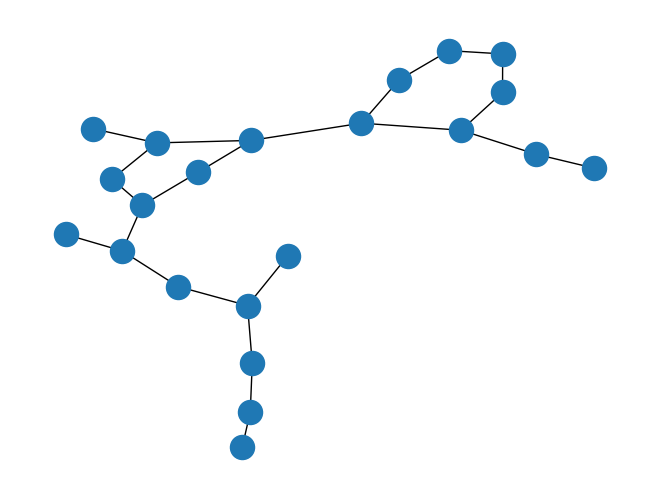

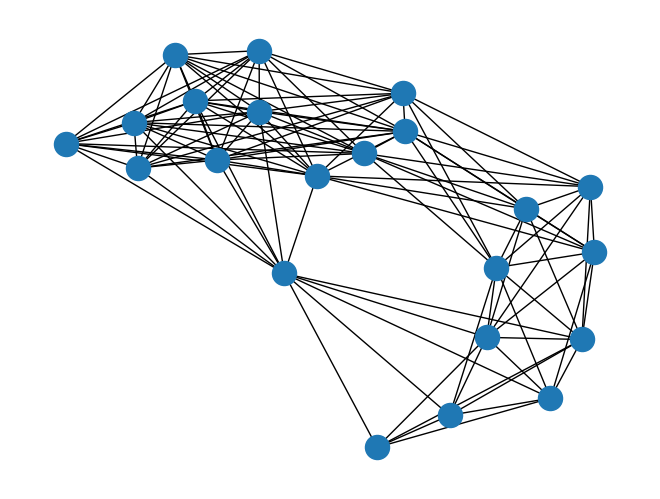

In [57]:
from torch_geometric.utils.convert import from_networkx, to_networkx

graphs = np.random.choice(len(test_data_list), gen_graphs, False)
for g_id in graphs:
    data = test_data_list[g_id]
    G = to_networkx(data).to_undirected()
    
    z = model.encode(data.x.float(), data.edge_index)
    graph_adj = model.decoder.forward_all(z)
    adj_binary = np.asarray((graph_adj > threshold).int())
    
    
    nx.draw(G)
    plt.show()
    pred_G = nx.from_numpy_array(adj_binary)
    pred_G.remove_edges_from(nx.selfloop_edges(pred_G))
    nx.draw(pred_G)
    
    
    plt.show()

In [ ]:
# visualising new graphs

# Section 2: Sequential Graph Generation: https://arxiv.org/abs/1803.03324
### Objective: Become familiar with a sequential graph generation method and dgl library

In [ ]:
!pip install dgl

In [62]:
import dgl

g = dgl.DGLGraph()
g.add_nodes(1)              # Add node 0
g.add_nodes(1)              # Add node 1

# Edges in DGLGraph are directed by default.
# For undirected edges, add edges for both directions.
g.add_edges([1, 0], [0, 1]) # Add edges (1, 0), (0, 1)
g.add_nodes(1)              # Add node 2
g.add_edges([2, 1], [1, 2]) # Add edges (2, 1), (1, 2)
g.add_edges([2, 0], [0, 2]) # Add edges (2, 0), (0, 2)

/Users/jks17/miniconda3/envs/gismo/lib/python3.8/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


# Sequential Decision Step
### ![sequential](figures/sequential.png)

In [63]:
def forward_inference(self):
    stop = self.add_node_and_update()
    while (not stop) and (self.g.number_of_nodes() < self.v_max + 1):
        num_trials = 0
        to_add_edge = self.add_edge_or_not()
        while to_add_edge and (num_trials < self.g.number_of_nodes() - 1):
            self.choose_dest_and_update()
            num_trials += 1
            to_add_edge = self.add_edge_or_not()
        stop = self.add_node_and_update()

    return self.g

### ![train](figures/train.png)

In [64]:
def forward_train(self, actions):
    """
    - actions: list
        - Contains a_1, ..., a_T described above
    - self.prepare_for_train()
        - Initializes self.action_step to be 0, which will get
          incremented by 1 every time it is called.
        - Initializes objects recording log p(a_t|a_1,...a_{t-1})

    Returns
    -------
    - self.get_log_prob(): log p(a_1, ..., a_T)
    """
    self.prepare_for_train()

    stop = self.add_node_and_update(a=actions[self.action_step])
    while not stop:
        to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
        while to_add_edge:
            self.choose_dest_and_update(a=actions[self.action_step])
            to_add_edge = self.add_edge_or_not(a=actions[self.action_step])
        stop = self.add_node_and_update(a=actions[self.action_step])

    return self.get_log_prob()

In [65]:
import torch.nn as nn


class DGMGSkeleton(nn.Module):
    def __init__(self, v_max):
        """
        Parameters
        ----------
        v_max: int
            Max number of nodes considered
        """
        super(DGMGSkeleton, self).__init__()

        # Graph configuration
        self.v_max = v_max

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""
        return NotImplementedError

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""
        return NotImplementedError

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""
        return NotImplementedError

    def forward_train(self, actions):
        """Forward at training time. It records the probability
        of generating a ground truth graph following the actions."""
        return NotImplementedError

    def forward_inference(self):
        """Forward at inference time.
        It generates graphs on the fly."""
        return NotImplementedError

    def forward(self, actions=None):
        # The graph you will work on
        self.g = dgl.DGLGraph()

        # If there are some features for nodes and edges,
        # zero tensors will be set for those of new nodes and edges.
        self.g.set_n_initializer(dgl.frame.zero_initializer)
        self.g.set_e_initializer(dgl.frame.zero_initializer)

        if self.training:
            return self.forward_train(actions=actions)
        else:
            return self.forward_inference()

### ![nodes](figures/add_nodes.png)

In [66]:
import torch.nn.functional as F
from torch.distributions import Bernoulli

def bernoulli_action_log_prob(logit, action):
    """Calculate the log p of an action with respect to a Bernoulli
    distribution. Use logit rather than prob for numerical stability."""
    if action == 0:
        return F.logsigmoid(-logit)
    else:
        return F.logsigmoid(logit)

class AddNode(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddNode, self).__init__()

        self.graph_op = {'embed': graph_embed_func}

        self.stop = 1
        self.add_node = nn.Linear(graph_embed_func.graph_hidden_size, 1)

        # If to add a node, initialize its hv
        self.node_type_embed = nn.Embedding(1, node_hidden_size)
        self.initialize_hv = nn.Linear(node_hidden_size + \
                                       graph_embed_func.graph_hidden_size,
                                       node_hidden_size)

        self.init_node_activation = torch.zeros(1, 2 * node_hidden_size)

    def _initialize_node_repr(self, g, node_type, graph_embed):
        """Whenver a node is added, initialize its representation."""
        num_nodes = g.number_of_nodes()
        hv_init = self.initialize_hv(
            torch.cat([
                self.node_type_embed(torch.LongTensor([node_type])),
                graph_embed], dim=1))
        g.nodes[num_nodes - 1].data['hv'] = hv_init
        g.nodes[num_nodes - 1].data['a'] = self.init_node_activation

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)

        logit = self.add_node(graph_embed)
        prob = torch.sigmoid(logit)

        if not self.training:
            action = Bernoulli(prob).sample().item()
        stop = bool(action == self.stop)

        if not stop:
            g.add_nodes(1)
            self._initialize_node_repr(g, action, graph_embed)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)

            self.log_prob.append(sample_log_prob)

        return stop

In [67]:
# Exercises: Convert the main functions from  DGL to pytorch

In [69]:
num_features, output_features = 3, 1
sigmoid = nn.Sigmoid()

h_g = torch.randn(num_features)
w_addnode = nn.Linear(num_features, 1)
bias_addnode = nn.Parameter(torch.zeros(1))

# exercise
op = sigmoid(w_addnode(h_g) + bias_addnode)

In [70]:
for _ in range(20):
    add_node = Bernoulli(op).sample().item()
    if add_node == 1:
        print('add node')
    else:
        print('dont add node and stop')

dont add node and stop
dont add node and stop
dont add node and stop
dont add node and stop
dont add node and stop
dont add node and stop
dont add node and stop
dont add node and stop
dont add node and stop
dont add node and stop
dont add node and stop
add node
dont add node and stop
add node
dont add node and stop
dont add node and stop
add node
add node
add node
dont add node and stop


In [71]:
# Initialise New Node embedding (Homework or Exercise)

### ![nodes](figures/add_edges.png)

In [72]:
class AddEdge(nn.Module):
    def __init__(self, graph_embed_func, node_hidden_size):
        super(AddEdge, self).__init__()

        self.graph_op = {'embed': graph_embed_func}
        self.add_edge = nn.Linear(graph_embed_func.graph_hidden_size + \
                                  node_hidden_size, 1)

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, action=None):
        graph_embed = self.graph_op['embed'](g)
        src_embed = g.nodes[g.number_of_nodes() - 1].data['hv']

        logit = self.add_edge(torch.cat(
            [graph_embed, src_embed], dim=1))
        prob = torch.sigmoid(logit)

        if self.training:
            sample_log_prob = bernoulli_action_log_prob(logit, action)
            self.log_prob.append(sample_log_prob)
        else:
            action = Bernoulli(prob).sample().item()

        to_add_edge = bool(action == 0)
        return to_add_edge


### ![nodes](figures/choose_dest.png)

In [73]:
from torch.distributions import Categorical

class ChooseDestAndUpdate(nn.Module):
    def __init__(self, graph_prop_func, node_hidden_size):
        super(ChooseDestAndUpdate, self).__init__()

        self.graph_op = {'prop': graph_prop_func}
        self.choose_dest = nn.Linear(2 * node_hidden_size, 1)

    def _initialize_edge_repr(self, g, src_list, dest_list):
        # For untyped edges, only add 1 to indicate its existence.
        # For multiple edge types, use a one-hot representation
        # or an embedding module.
        edge_repr = torch.ones(len(src_list), 1)
        g.edges[src_list, dest_list].data['he'] = edge_repr

    def prepare_training(self):
        self.log_prob = []

    def forward(self, g, dest):
        src = g.number_of_nodes() - 1
        possible_dests = range(src)

        src_embed_expand = g.nodes[src].data['hv'].expand(src, -1)
        possible_dests_embed = g.nodes[possible_dests].data['hv']

        dests_scores = self.choose_dest(
            torch.cat([possible_dests_embed,
                       src_embed_expand], dim=1)).view(1, -1)
        dests_probs = F.softmax(dests_scores, dim=1)

        if not self.training:
            dest = Categorical(dests_probs).sample().item()

        if not g.has_edge_between(src, dest):
            # For undirected graphs, add edges for both directions
            # so that you can perform graph propagation.
            src_list = [src, dest]
            dest_list = [dest, src]

            g.add_edges(src_list, dest_list)
            self._initialize_edge_repr(g, src_list, dest_list)

            self.graph_op['prop'](g)

        if self.training:
            if dests_probs.nelement() > 1:
                self.log_prob.append(
                    F.log_softmax(dests_scores, dim=1)[:, dest: dest + 1])

In [81]:
# We can convert the main function here to pytorch
num_nodes = 10
num_features = 3
current_node_embeddings = torch.randn(num_nodes, num_features)   # (10 x 3 matrix)
new_node_embedding = torch.randn(num_features).repeat(num_nodes).reshape(num_nodes, num_features)   # (10 x 3 matrix)

# Exercise
choose_dest =  nn.Linear(2 * num_features, 1)
dests_scores = choose_dest(
            torch.cat([current_node_embeddings,
                       new_node_embedding], dim = 1)).view(1, -1)

dests_probs = F.softmax(dests_scores, dim=1)
print(Categorical(dests_probs).sample().item())


3


In [68]:
class DGMG(DGMGSkeleton):
    def __init__(self, v_max, node_hidden_size,
                 num_prop_rounds):
        super(DGMG, self).__init__(v_max)

        # Graph embedding module
        #self.graph_embed = Embed Graph

        # Graph propagation module
        #self.graph_prop = GCN (for example)

        # Actions
        self.add_node_agent = AddNode(
            self.graph_embed, node_hidden_size)
        self.add_edge_agent = AddEdge(
            self.graph_embed, node_hidden_size)
        self.choose_dest_agent = ChooseDestAndUpdate(
            self.graph_prop, node_hidden_size)

        # Forward functions
        self.forward_train = partial(forward_train, self=self)
        self.forward_inference = partial(forward_inference, self=self)

    @property
    def action_step(self):
        old_step_count = self.step_count
        self.step_count += 1

        return old_step_count

    def prepare_for_train(self):
        self.step_count = 0

        self.add_node_agent.prepare_training()
        self.add_edge_agent.prepare_training()
        self.choose_dest_agent.prepare_training()

    def add_node_and_update(self, a=None):
        """Decide if to add a new node.
        If a new node should be added, update the graph."""

        return self.add_node_agent(self.g, a)

    def add_edge_or_not(self, a=None):
        """Decide if a new edge should be added."""

        return self.add_edge_agent(self.g, a)

    def choose_dest_and_update(self, a=None):
        """Choose destination and connect it to the latest node.
        Add edges for both directions and update the graph."""

        self.choose_dest_agent(self.g, a)

    def get_log_prob(self):
        add_node_log_p = torch.cat(self.add_node_agent.log_prob).sum()
        add_edge_log_p = torch.cat(self.add_edge_agent.log_prob).sum()
        choose_dest_log_p = torch.cat(self.choose_dest_agent.log_prob).sum()
        return add_node_log_p + add_edge_log_p + choose_dest_log_p

In [ ]:
# Homework: Train This model: You can Follow the code from here: https://github.com/dmlc/dgl/blob/master/examples/pytorch/dgmg/main.py

# Sequential Example
### ![sequential_example](figures/sequence_gen.png)

# Section 3: Graph Generative Model Evaluation (GGME)
### Objective: Become familiar with evaluation techniques for GGME

# GGME
![GGME](figures/graph_distance.png)

### Example Evaluation from Digress: Discrete Denoising Diffusion: https://arxiv.org/pdf/2209.14734.pdf
![eval](figures/example_eval.png)

In [45]:
# Example
sizes = [50, 50]

# Define testing set distribution
test_probs = [[0.25, 0.85], [0.85, 0.25]]
test_graphs = [nx.stochastic_block_model(sizes, test_probs) for _ in range(100)]

# our first generative model
gen_prob1 = [[0.2, 0.85], [0.85, 0.2]]
graph_distribution1 = [nx.stochastic_block_model(sizes, gen_prob1) for _ in range(100)]

# second generative model
gen_prob2 = [[0.15, 0.85], [0.85, 0.15]]
graph_distribution2 = [nx.stochastic_block_model(sizes, gen_prob2) for _ in range(100)]

### Maximum Mean Discrepancy (MMD): https://www.jmlr.org/papers/volume13/gretton12a/gretton12a.pdf
![mmd](figures/mmd.png)

In [46]:
# code taken from https://github.com/BorgwardtLab/ggme/tree/main and https://github.com/KarolisMart/SPECTRE

def disc(samples1, samples2, kernel, is_parallel=True, *args, **kwargs):
    ''' Discrepancy between 2 samples '''
    d = 0

    for s1 in samples1:
        for s2 in samples2:
            d += kernel(s1, s2, *args, **kwargs)
            
    if len(samples1) * len(samples2) > 0:
        d /= len(samples1) * len(samples2)
    else:
        d = 1e+6
    return d


def compute_mmd(samples1, samples2, kernel, is_hist=True, *args, **kwargs):
    ''' MMD between two samples '''
    # normalize histograms into pmf
    if is_hist:
        samples1 = [s1 / (np.sum(s1) + 1e-6) for s1 in samples1]
        samples2 = [s2 / (np.sum(s2) + 1e-6) for s2 in samples2]
    return disc(samples1, samples1, kernel, *args, **kwargs) + disc(samples2, samples2, kernel, *args, **kwargs) - \
                2 * disc(samples1, samples2, kernel, *args, **kwargs)

def gaussian_tv(x, y, sigma=1.0):  
    support_size = max(len(x), len(y))
    # convert histogram values x and y to float, and make them equal len
    x = x.astype(float)
    y = y.astype(float)
    if len(x) < len(y):
        x = np.hstack((x, [0.0] * (support_size - len(x))))
    elif len(y) < len(x):
        y = np.hstack((y, [0.0] * (support_size - len(y))))

    dist = np.abs(x - y).sum() / 2.0
    return np.exp(-dist * dist / (2 * sigma * sigma))

In [47]:
def degree_stats(graph_ref_list, graph_pred_list):
    ''' Compute the distance between the degree distributions of two unordered sets of graphs.
        Args:
            graph_ref_list, graph_target_list: two lists of networkx graphs to be evaluated
        '''
    sample_ref = []
    sample_pred = []
    
    for i in range(len(graph_ref_list)):
        degree_temp = np.array(nx.degree_histogram(graph_ref_list[i]))  # degree histogram
        sample_ref.append(degree_temp)
    for i in range(len(graph_pred_list)):
        degree_temp = np.array(
            nx.degree_histogram(graph_pred_list[i]))
        sample_pred.append(degree_temp)

    mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_tv)
    
    return mmd_dist

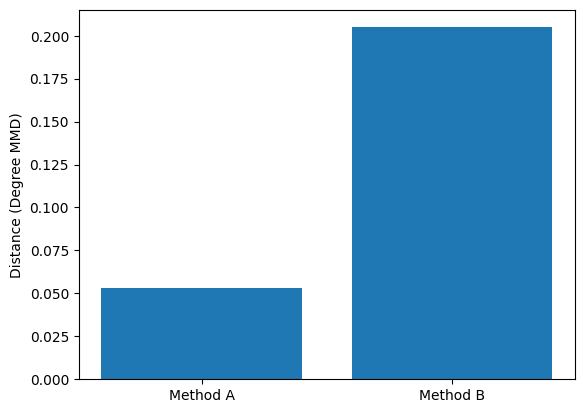

In [48]:
dist_1 = degree_stats(test_graphs, graph_distribution1)
dist_2 = degree_stats(test_graphs, graph_distribution2)

plt.bar(['Method A','Method B'],[dist_1, dist_2])
plt.ylabel('Distance (Degree MMD)')
plt.show()

In [49]:
def clustering_stats(graph_ref_list,
                     graph_pred_list,
                     bins=100,
                     is_parallel=True, compute_emd=False):
    sample_ref = []
    sample_pred = []
    for i in range(len(graph_ref_list)):
        clustering_coeffs_list = list(nx.clustering(graph_ref_list[i]).values())
        hist, _ = np.histogram(
            clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
        sample_ref.append(hist)

    for i in range(len(graph_pred_list)):
        clustering_coeffs_list = list(
            nx.clustering(graph_pred_list[i]).values())
        hist, _ = np.histogram(
            clustering_coeffs_list, bins=bins, range=(0.0, 1.0), density=False)
        sample_pred.append(hist)

    mmd_dist = compute_mmd(sample_ref, sample_pred, kernel=gaussian_tv, sigma=1.0 / 10)
    
    return mmd_dist

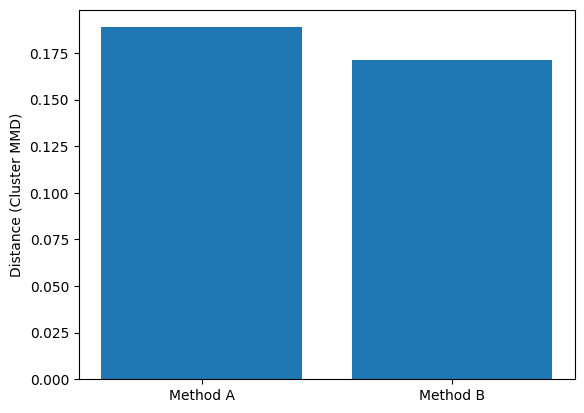

In [50]:
dist_1 = clustering_stats(test_graphs, graph_distribution1)
dist_2 = clustering_stats(test_graphs, graph_distribution2)

plt.bar(['Method A','Method B'],[dist_1, dist_2])
plt.ylabel('Distance (Cluster MMD)')
plt.show()

In [ ]:
# Homework: Can you extend to other measures beyond degree and clustering coefficient?
# In this particular case, what would be a good measure to seperate these SBMs?

### V.U.N stands for valid, unique and novel

In [ ]:
# Valid -> Is an SBM graph
# unique -> Fraction of generated graphs which are not the same as eachother
# Novelty -> Fraction of graphs not in training set

'''
def is_sbm_graph(G, p_intra=0.3, p_inter=0.005, strict=True, refinement_steps=1000):
    """
    Check if how closely given graph matches a SBM with given probabilites by computing mean probability of Wald test statistic for each recovered parameter
    """

    adj = nx.adjacency_matrix(G).toarray()
    idx = adj.nonzero()
    g = gt.Graph()
    g.add_edge_list(np.transpose(idx))
    try:
        state = gt.minimize_blockmodel_dl(g)
    except ValueError:
        if strict:
            return False
        else:
            return 0.0

    # Refine using merge-split MCMC
    for i in range(refinement_steps):
        state.multiflip_mcmc_sweep(beta=np.inf, niter=10)

    b = state.get_blocks()
    b = gt.contiguous_map(state.get_blocks())
    state = state.copy(b=b)
    e = state.get_matrix()
    n_blocks = state.get_nonempty_B()
    node_counts = state.get_nr().get_array()[:n_blocks]
    edge_counts = e.todense()[:n_blocks, :n_blocks]
    if strict:
        if (node_counts > 40).sum() > 0 or (node_counts < 20).sum() > 0 or n_blocks > 5 or n_blocks < 2:
            return False

    max_intra_edges = node_counts * (node_counts - 1)
    est_p_intra = np.diagonal(edge_counts) / (max_intra_edges + 1e-6)

    max_inter_edges = node_counts.reshape((-1, 1)) @ node_counts.reshape((1, -1))
    np.fill_diagonal(edge_counts, 0)
    est_p_inter = edge_counts / (max_inter_edges + 1e-6)

    W_p_intra = (est_p_intra - p_intra) ** 2 / (est_p_intra * (1 - est_p_intra) + 1e-6)
    W_p_inter = (est_p_inter - p_inter) ** 2 / (est_p_inter * (1 - est_p_inter) + 1e-6)

    W = W_p_inter.copy()
    np.fill_diagonal(W, W_p_intra)
    p = 1 - chi2.cdf(abs(W), 1)
    p = p.mean()
    if strict:
        return p > 0.9  # p value < 10 %
    else:
        return p

'''

### Molecule Generation Evaluation: https://www.frontiersin.org/journals/pharmacology/articles/10.3389/fphar.2020.565644/full
![mmd](figures/molecule.png)